In [1]:
import lightkurve as lk
import astropy.table as astab
import pandas as pd
import numpy as np
import astropy
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
# %pylab inline
# pylab.rcParams['figure.figsize'] = (16, 8)
import warnings
import astropy.table as astab
from astropy.io import fits

warnings.filterwarnings('ignore',
    message="WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size:"
)
print(astropy.__version__)

import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess
import exoplanet as xo

import arviz as az
from corner import corner

from scipy.signal import savgol_filter

# %matplotlib widget
dd = "/Users/kjaehnig/CCA_work/GAT/"

def docs_setup():
    """Set some environment variables and ignore some warnings for the docs"""
    import logging
    import warnings


    # Remove when Theano is updated
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Remove when arviz is updated
    warnings.filterwarnings("ignore", category=UserWarning)

    logger = logging.getLogger("theano.gof.compilelock")
    logger.setLevel(logging.ERROR)
    logger = logging.getLogger("theano.tensor.opt")
    logger.setLevel(logging.ERROR)
    logger = logging.getLogger("exoplanet")
    logger.setLevel(logging.DEBUG)

docs_setup()

4.3.1


# LOAD IN ALLVISIT FILE (an absolute unit: ~ 2.75GB)

In [2]:
allvis17 = astab.Table.read("/Users/kjaehnig/CCA_work/GAT/dr17_joker/allVisit-dr17-synspec.fits",hdu=1, format='fits')
allstar17 = astab.Table.read("/Users/kjaehnig/CCA_work/GAT/dr17_joker/allStar-dr17-synspec-gaiaedr3-xm.fits")
allstar17 = allstar17[(allstar17['bp_rp'] < 10) & (allstar17['phot_g_mean_mag'] < 25)]
calibverr = astab.Table.read(dd+'dr17_joker/allVisit-dr17-synspec-min3-calibverr.fits', format='fits', hdu=1)


print(len(allvis17['APOGEE_ID']))
print(allvis17.columns)
hq_jk_allstar_tess_edr3 = astab.Table.read(dd+'dr17_joker/unimodal_joker_sample_joined_w_tess_edr3_REDUX.fits', format='fits')
print(len(hq_jk_allstar_tess_edr3))

2659178
<TableColumns names=('APOGEE_ID','TARGET_ID','VISIT_ID','FILE','FIBERID','CARTID','PLATE','MJD','TELESCOPE','SURVEY','FIELD','PROGRAMNAME','ALT_ID','LOCATION_ID','RA','DEC','GLON','GLAT','RELFLUX','MTPFLUX','J','J_ERR','H','H_ERR','K','K_ERR','SRC_H','WASH_M','WASH_M_ERR','WASH_T2','WASH_T2_ERR','DDO51','DDO51_ERR','IRAC_3_6','IRAC_3_6_ERR','IRAC_4_5','IRAC_4_5_ERR','IRAC_5_8','IRAC_5_8_ERR','IRAC_8_0','IRAC_8_0_ERR','WISE_4_5','WISE_4_5_ERR','TARG_4_5','TARG_4_5_ERR','WASH_DDO51_GIANT_FLAG','WASH_DDO51_STAR_FLAG','PMRA','PMDEC','PM_SRC','AK_TARG','AK_TARG_METHOD','AK_WISE','SFD_EBV','APOGEE_TARGET1','APOGEE_TARGET2','APOGEE_TARGET3','APOGEE_TARGET4','TARGFLAGS','SNR','STARFLAG','STARFLAGS','DATEOBS','JD','VLSR','VGSR','CHISQ','SYNTHFILE','MIN_H','MAX_H','MIN_JK','MAX_JK','VREL','VRELERR','VHELIO','BC','RV_TEFF','RV_LOGG','RV_FEH','RV_CARB','RV_ALPHA','XCORR_VREL','XCORR_VRELERR','XCORR_VHELIO','CCFWHM','AUTOFWHM','RV_CHI2','N_COMPONENTS','RV_COMPONENTS','RV_FLAG')>
1741


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/4214507395.py:3: RuntimeWarning: invalid value encountered in log10
  ax.plot(allstar17['bp_rp'], allstar17['phot_bp_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5), marker=',',ls='None',c='gray')
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/4214507395.py:9: RuntimeWarning: invalid value encountered in log10
  - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


Text(0, 0.5, 'G')

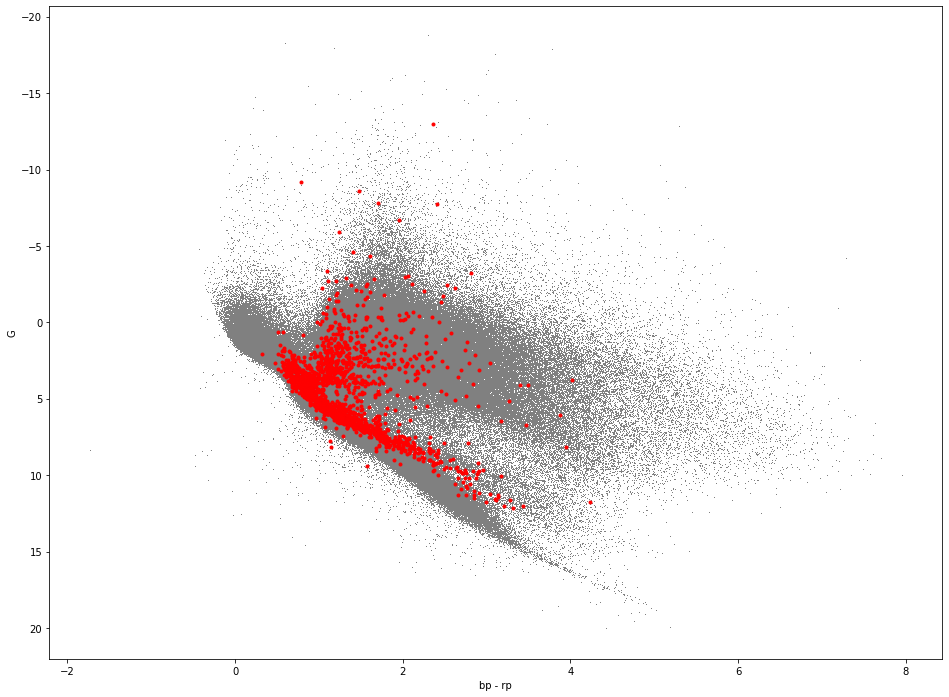

In [3]:
fig,ax = plt.subplots(figsize=(16,12))

ax.plot(allstar17['bp_rp'], allstar17['phot_bp_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5), marker=',',ls='None',c='gray')
y1,y2 = ax.set_ylim()
ax.set_ylim(y2,y1)

ax.plot(hq_jk_allstar_tess_edr3['bp_rp'], 
        hq_jk_allstar_tess_edr3['phot_g_mean_mag'] 
         - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)
           , c='red', marker='.', ls='None') 
ax.set_xlabel("bp - rp")
ax.set_ylabel("G")

114 57


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/2459686942.py:18: RuntimeWarning: invalid value encountered in log10
  ax.plot(allstar17['bp_rp'], allstar17['phot_bp_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5), marker=',',ls='None',c='gray')
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/2459686942.py:24: RuntimeWarning: invalid value encountered in log10
  - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


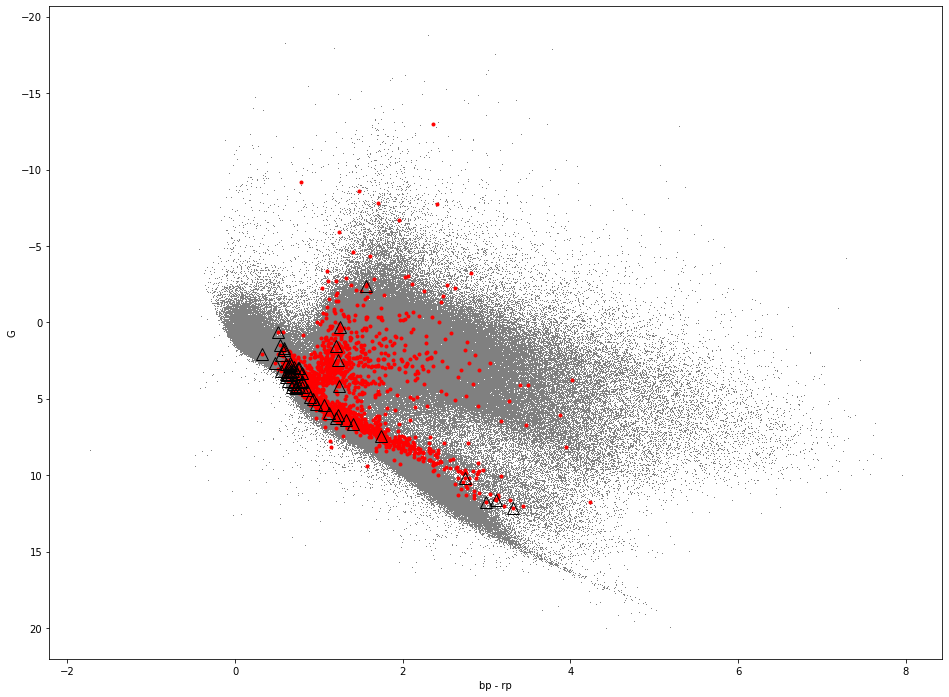

In [4]:
import pickle as pk
import os
dir_ticIDS = os.listdir(dd+'joker_TESS_lightcurve_files')
dir_ticIDS.remove(".DS_Store")

dir_ticIDS = [ii.replace('_lightcurve_data.pickle','') for ii in dir_ticIDS]
dir_ticIDS = [ii.replace('_highres_bls_params.pickle','') for ii in dir_ticIDS]

print(len(dir_ticIDS),len(np.unique(dir_ticIDS)))
dir_ticIDS = np.unique(dir_ticIDS)
right_ids = 0

has_tess_obs = np.in1d(hq_jk_allstar_tess_edr3['ID'],[int(ii.split('_')[1]) for ii in dir_ticIDS])
hq_jk_allstar_tess_edr3_w_tess_obs = hq_jk_allstar_tess_edr3[has_tess_obs]

fig,ax = plt.subplots(figsize=(16,12))

ax.plot(allstar17['bp_rp'], allstar17['phot_bp_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5), marker=',',ls='None',c='gray')
y1,y2 = ax.set_ylim()
ax.set_ylim(y2,y1)

ax.plot(hq_jk_allstar_tess_edr3['bp_rp'], 
        hq_jk_allstar_tess_edr3['phot_g_mean_mag'] 
         - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)
           , c='red', marker='.', ls='None') 
ax.set_xlabel("bp - rp")
ax.set_ylabel("G")

ax.plot(hq_jk_allstar_tess_edr3_w_tess_obs['bp_rp'],
        hq_jk_allstar_tess_edr3_w_tess_obs['phot_g_mean_mag']
        - (5.*np.log10(1000./hq_jk_allstar_tess_edr3_w_tess_obs['parallax']) - 5)
        , c='black', marker='^', ms=12,ls='None',mfc='None')

file = open("/Users/kjaehnig/CCA_work/GAT/tic_ids_of_systems_with_short_cadence_obs.txt",'w')
for ii in dir_ticIDS:
    file.write(ii+'\n')
file.close()

In [5]:
big_tess_lc_dict = {}
print(dir_ticIDS)
for ii in dir_ticIDS:
    file = open(f"/Users/kjaehnig/CCA_work/GAT/joker_TESS_lightcurve_files/{ii}_lightcurve_data.pickle",'rb')
    res = pk.load(file)
    file.close()
    big_tess_lc_dict[ii] = res
file = open("/Users/kjaehnig/CCA_work/GAT/big_lightcurve_dict_shortcadence_tess_obs","wb")
pk.dump(big_tess_lc_dict, file)
file.close()



['TIC_118589804' 'TIC_122304930' 'TIC_126232983' 'TIC_137318531'
 'TIC_137547180' 'TIC_138291351' 'TIC_144424576' 'TIC_144441148'
 'TIC_149539552' 'TIC_158324163' 'TIC_158786520' 'TIC_160072933'
 'TIC_162595188' 'TIC_164458426' 'TIC_164527723' 'TIC_164892194'
 'TIC_165453878' 'TIC_169820068' 'TIC_199497770' 'TIC_20215452'
 'TIC_202371935' 'TIC_219694227' 'TIC_229536143' 'TIC_230064750'
 'TIC_232540911' 'TIC_258108067' 'TIC_261205404' 'TIC_269655424'
 'TIC_271548206' 'TIC_272074664' 'TIC_27530133' 'TIC_28159019'
 'TIC_28188792' 'TIC_28240436' 'TIC_297823453' 'TIC_307857044'
 'TIC_32792896' 'TIC_358154514' 'TIC_365204192' 'TIC_38515566'
 'TIC_39139656' 'TIC_393799536' 'TIC_396928724' 'TIC_399965207'
 'TIC_408018644' 'TIC_423571075' 'TIC_425825018' 'TIC_450325128'
 'TIC_453823509' 'TIC_461630038' 'TIC_461736494' 'TIC_49823764'
 'TIC_77561252' 'TIC_82546444' 'TIC_9429166' 'TIC_97757876' 'TIC_99254945']


(array([ 11.,  30.,  77., 122., 178., 657., 530., 121.,  11.,   4.]),
 array([ 7.678004 ,  8.970924 , 10.2638445, 11.556765 , 12.849685 ,
        14.142605 , 15.435525 , 16.728445 , 18.021366 , 19.314285 ,
        20.607206 ], dtype=float32),
 <BarContainer object of 10 artists>)

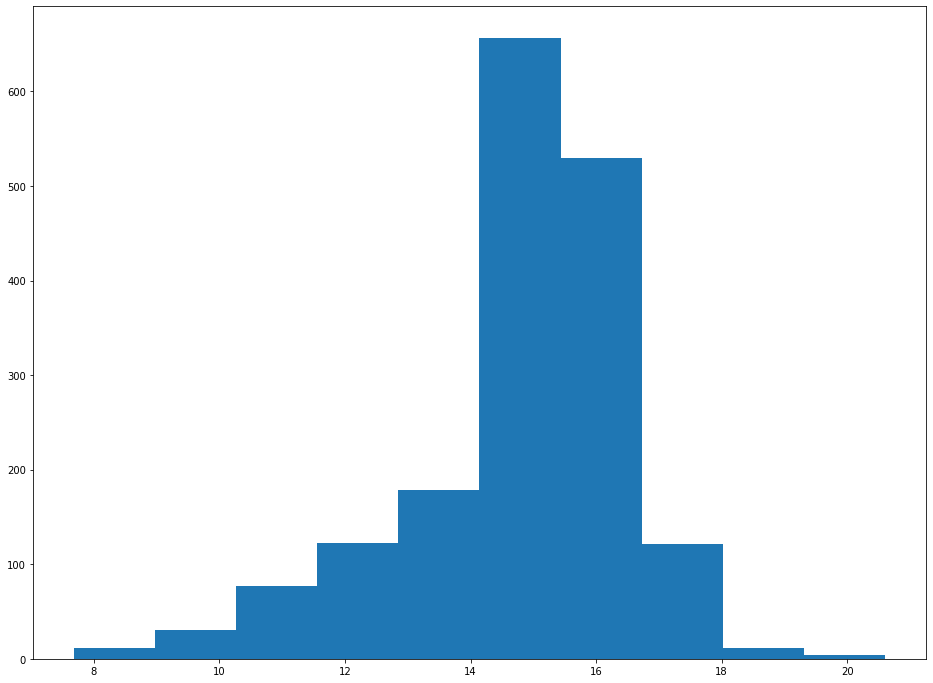

In [6]:
fig,ax = plt.subplots(figsize=(16,12))
ax.hist(hq_jk_allstar_tess_edr3['phot_g_mean_mag'])

#### Load in relevant cross-matches and grab Joker Params for specific TIC ID

In [7]:
target_tic = 'TIC 272074664'
def grab_apogee_rv_data_w_ticID(target_tic='TIC 20215452'):
#     target_tic = 'TIC 20215452'

    #cross-matched star table (has source_id, apogee_id, TIC_id)
    hq_jk_allstar_tess_edr3 = astab.Table.read(dd+'dr17_joker/unimodal_joker_sample_joined_w_tess_edr3.fits', format='fits')

    #Adrian's calibrated RV_ERRs
    calibverr = astab.Table.read(dd+'dr17_joker/allVisit-dr17-synspec-min3-calibverr.fits', format='fits', hdu=1)
#     print(calibverr.info)
    # Grab cross-match IDs
    jk_row = hq_jk_allstar_tess_edr3[hq_jk_allstar_tess_edr3['ID'] == int(target_tic.split(' ')[1])]


    sysapodat = allvis17[allvis17['APOGEE_ID'] == jk_row['APOGEE_ID']]

    ## joining calib RV_ERRs with the RVs
    sysapodat = astab.join(sysapodat, calibverr['VISIT_ID','CALIB_VERR'], keys=('VISIT_ID','VISIT_ID'))
#     print(calibverr.info, sysapodat.columns)
    x_rv = sysapodat['JD'] 
    xrv_sorted_ind = np.argsort(x_rv)

    x_rv = x_rv[xrv_sorted_ind]
    y_rv = sysapodat['VHELIO'][xrv_sorted_ind]
    yerr_rv = sysapodat['CALIB_VERR'][xrv_sorted_ind]

    map_t0_bmjd = jk_row['MAP_t0_bmjd']
    t0_bmjd = astropy.time.Time(map_t0_bmjd, format='mjd', scale='tcb')
    t0_bjd = t0_bmjd.tcb.jd

    return ((x_rv, y_rv, yerr_rv),
            jk_row,
            sysapodat
           )


rvdat,jk_row,sysapodat = grab_apogee_rv_data_w_ticID(target_tic=target_tic)
x_rv, y_rv, yerr_rv = rvdat


   MAP_t0_bmjd    
------------------
56934.930298495645       MAP_P       
        d         
------------------
10.476256370544434


'plot multiple tic ids with folded lightcurves and RVs using the BLS period/t0 from the TESS data\n'

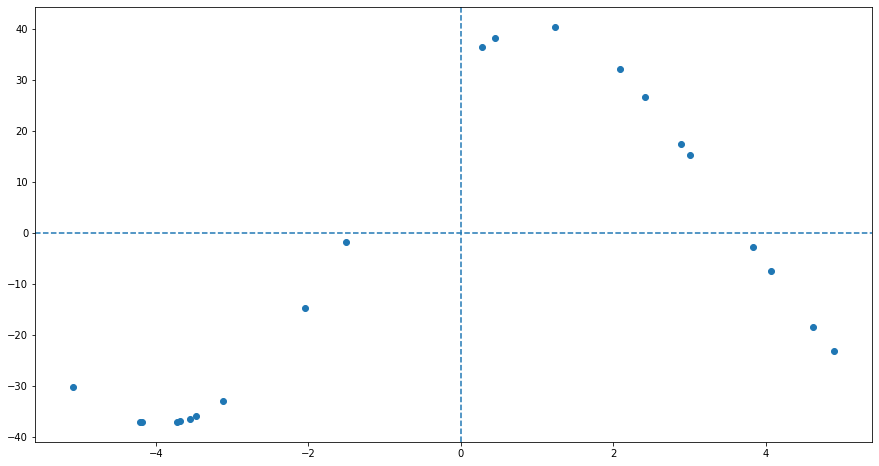

In [8]:
#### DEFINE THE RV,RV_ERRs, and X_RVs for later use in the mcmc... DO NOT REDEFINE ME OR YOU MAKE PYMC3 SAD
# x_rv = sysapodat['JD'] 
# xrv_sorted_ind = np.argsort(x_rv)

# x_rv = x_rv[xrv_sorted_ind]
# y_rv = sysapodat['VHELIO'][xrv_sorted_ind]
# yerr_rv = sysapodat['CALIB_VERR'][xrv_sorted_ind]

map_t0_bmjd = jk_row['MAP_t0_bmjd']
t0_bmjd = astropy.time.Time(map_t0_bmjd, format='mjd', scale='tcb')
t0_bjd = t0_bmjd.tcb.jd

fit,ax = plt.subplots(nrows=1, figsize=(15,8))
print(jk_row['MAP_t0_bmjd'], jk_row['MAP_P'])

plot_per = jk_row['MAP_P'].value
plot_t0 = t0_bjd


ax.scatter(((x_rv - plot_t0 + 0.5*plot_per) % plot_per) - 0.5 * plot_per, y_rv-jk_row['MAP_v0'],)
ax.axhline(0.0,ls='--')
ax.axvline(0.0,ls='--')
# 7.689283720758311 d 1901.7952219793171
# ax.scatter((x_rv-min(x_rv))%jk_row['MAP_P'], y_rv)
# ax.scatter(((x_rv -min(x_rv) + 0.5*jk_row['MAP_P']) % jk_row['MAP_P']) - 0.5 * jk_row['MAP_P'], y_rv)

"""plot multiple tic ids with folded lightcurves and RVs using the BLS period/t0 from the TESS data
"""

In [9]:
target_lk = lk.search_lightcurve('TIC 272074664',
             mission='TESS',
            cadence='short',
            author='SPOC'
             )
print(target_lk)
unpro_lks = target_lk.download_all(quality_bitmask='hardest')
lks = unpro_lks.stitch(corrector_func=lambda x: x.remove_nans().normalize().flatten())

lks_2019 = unpro_lks[:2].stitch(corrector_func=lambda x: x.remove_nans().normalize().flatten())
lks_2021 = unpro_lks[2:].stitch(corrector_func=lambda x: x.remove_nans().normalize().flatten())
unpro_lks[0].sector

SearchResult containing 4 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 14 2019   SPOC     120   272074664      0.0
  1 TESS Sector 15 2019   SPOC     120   272074664      0.0
  2 TESS Sector 40 2021   SPOC     120   272074664      0.0
  3 TESS Sector 41 2021   SPOC     120   272074664      0.0


14

In [10]:
def get_multiple_ranges(lk_coll):
    from itertools import groupby
    from operator import itemgetter

    ranges =[]
    inds = []
    data = [ii.sector for ii in lk_coll]
    for k,g in groupby(enumerate(data),lambda x:x[0]-x[1]):
        group = (map(itemgetter(1),g))
        group = list(map(int,group))
        inds.append([ii in group for ii in data])
        ranges.append((group[0],group[-1]))
        
    return data,ranges, inds
dat,rng,ind = get_multiple_ranges(unpro_lks)

print(dat)
print(len(ind))


[14, 15, 40, 41]
2


In [11]:
with fits.open(unpro_lks[0].filename) as hdu:
    hdr = hdu[1].header

texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
print(texp, texp*60*60*24)



0.001388888888888889 120.00000000000003


In [23]:
from matplotlib import cm


def get_multiple_ranges(lk_coll):
    from itertools import groupby
    from operator import itemgetter

    ranges =[]
    inds = []
    data = [ii.sector for ii in lk_coll]
    for k,g in groupby(enumerate(data),lambda x:x[0]-x[1]):
        group = (map(itemgetter(1),g))
        group = list(map(int,group))
        inds.append([ii in group for ii in data])
        ranges.append((group[0],group[-1]))
        
    return data,ranges,inds


def get_all_transit_params(TIC_ID, jk_row):
    
    res = {'periods':[],
          'durations':[],
          't0s':[],
          'depths':[]}
    
    period_grid = np.exp(np.linspace(np.log(0.5*jk_row['MAP_P']),
                                     np.log(2.*jk_row['MAP_P']),
                                     10000)).squeeze()
    
#     period_grid = np.exp(np.linspace(np.log(0.1), np.log(100),1000))
    dur_grid = np.exp(np.linspace(np.log(0.001),np.log(0.09),50))

    npts = 5000
    pmin = period_grid.min()
    pmax = period_grid.max()
    mindur = dur_grid.min()

    print("Downloading all available TESS data.")
    lk_search = lk.search_lightcurve(TIC_ID,
             mission='TESS',
            cadence='short',
            author='SPOC'
             )
    
    unprocessed_lkcoll = lk_search.download_all(quality_bitmask='hardest')
    all_lks = unprocessed_lkcoll.stitch(corrector_func=lambda x: x.remove_nans().normalize().flatten())
    
    print("Separating TESS sector data into groups.")
    _, __, grp_ind = get_multiple_ranges(unprocessed_lkcoll)
    
    for ii,ind in enumerate(grp_ind):
        
        print(f"Running BLS on group {ii}, sectors: {unprocessed_lkcoll[ind].sector}")
        lkgrp = unprocessed_lkcoll[ind].stitch(corrector_func=lambda x: x.remove_nans().normalize().flatten())
        
        maxtime = lkgrp.time.max().value
        mintime = lkgrp.time.min().value

        freq_f = int( ((pmin**-1 - pmax**-1) * (maxtime - mintime)**2) / (npts * mindur) ) 
        
        lkgrpBLS = lkgrp.to_periodogram('bls',
                                period=period_grid,
                                frequency_factor = freq_f, duration=dur_grid)
        
        res['periods'].append(lkgrpBLS.period_at_max_power.value)
        res['t0s'].append(lkgrpBLS.transit_time_at_max_power)
        res['durations'].append(lkgrpBLS.duration_at_max_power.value)
        res['depths'].append(lkgrpBLS.depth_at_max_power)
        
    print("Finished.")
    res['unprocessed_lk_coll'] = unprocessed_lkcoll
    res['all_lks'] = all_lks
    res['period_linspace'] = [0.5*jk_row['MAP_P'], 2.*jk_row['MAP_P'], len(period_grid)]
    res['dur_linspace'] = [0.001,0.09, len(dur_grid)]
    res['freq_factor'] = freq_f
    
    return res

def fold(x, period, t0):
    hp = 0.5 * period
    return (x - t0 + hp) % period - hp

def make_folded_lightcurve_from_blsres(TICID):
    
    file = open(f"/Users/kjaehnig/CCA_work/GAT/joker_TESS_lightcurve_files/{TICID.replace(' ','_').replace('-','_')}_highres_bls_params.pickle",'rb')
    blsres = pk.load(file)
    file.close()

    file = open(f"/Users/kjaehnig/CCA_work/GAT/joker_TESS_lightcurve_files/{TICID.replace(' ','_').replace('-','_')}_lightcurve_data.pickle","rb")
    res = pk.load(file)
    file.close()
    
        #     print(calibverr.info)
    # Grab cross-match IDs
    sysapodat = allvis17[allvis17['APOGEE_ID'] == res['joker_param']['APOGEE_ID']]

    ## joining calib RV_ERRs with the RVs
    sysapodat = astab.join(sysapodat, calibverr['VISIT_ID','CALIB_VERR'], keys=('VISIT_ID','VISIT_ID'))

    
    
    lks = res['all_lks']
#     print([len(ii) for ii in blsres['period']])
    print('sectors: ',res['lk_coll'].sector,'\n'\
          'bls_per(s): ',blsres['period'],'\n'\
          'MAP_P: ',res['joker_param']['MAP_P'])

    map_period = res['joker_param']['MAP_P']
    map_t0_bmjd = res['joker_param']['MAP_t0_bmjd']
    map_t0 = astropy.time.Time(map_t0_bmjd, format='mjd', scale='tcb')

    bls_period = blsres['period_at_max_power'].value
    bls_t0 = blsres['t0_at_max_power'].value
    
    fig,ax = plt.subplots(figsize=(16,20), nrows=4, ncols=2)
    ax[-1,-1].remove()
    
    fig.text(0.5,0.885,f'un-folded observations (TESS --- APOGEE) [{TICID}]',
             fontdict={'horizontalalignment':'center','fontweight':'bold','fontsize':14})
    lc_unfolded = ax[0,0].plot(lks.time.value, lks.flux.value,marker=',', ls='None',
                              )
    rv_time = astropy.time.Time(sysapodat['MJD'], format='mjd', scale='tcb')
    rv_unfolded = ax[0,1].plot(rv_time.btjd, 
                               sysapodat['VHELIO'] - res['joker_param']['MAP_v0'],
                               marker='o',ls='None',mec='black')
    
    fig.text(0.5,0.69,'bls folded observations (TESS --- APOGEE)',
             fontdict={'horizontalalignment':'center','fontweight':'bold','fontsize':14})
    
    abs_time_vmin = 0.0
    abs_time_vmax = max(lks.time.btjd.max()-lks.time.btjd.min(), rv_time.btjd.max()-rv_time.btjd.min())
    print(abs_time_vmin, abs_time_vmax)
    
    lc_folded_bls = ax[1,0].scatter(fold(lks.time.value, bls_period, bls_t0), 
               lks.flux.value, marker='o',s=0.5,
               c=lks.time.value - lks.time.min().value,
               cmap=cm.inferno, vmin=abs_time_vmin, vmax=abs_time_vmax#fold(lks.time.value, bls_period, bls_t0)
                )
    
    rv_folded_bls = ax[1,1].scatter(fold(sysapodat['MJD'].value, bls_period, blsres['t0_at_max_power'].mjd),
                                    sysapodat['VHELIO']-res['joker_param']['MAP_v0'],
                                    marker='o',c=sysapodat['MJD'].value-min(sysapodat['MJD']),
                                    cmap=cm.inferno, vmin=abs_time_vmin, vmax=abs_time_vmax,
                                    ec='black')
    ax[1,1].axvline(0.0,ls='--')
    ax[1,1].axhline(0.0,ls='--')

    fig.text(0.5,0.49,'MAP folded observations (TESS --- APOGEE)',
             fontdict={'horizontalalignment':'center','fontweight':'bold','fontsize':14})
    lc_folded_map = ax[2,0].scatter(fold(lks.time.value, map_period, map_t0.btjd), 
               lks.flux.value, marker='o',s=0.5,
               c=lks.time.value - lks.time.min().value,
               cmap=cm.inferno, vmin=abs_time_vmin, vmax=abs_time_vmax#fold(lks.time.value, bls_period, bls_t0)
                )
    
    rv_folded_map = ax[2,1].scatter(fold(sysapodat['MJD'].value, map_period, map_t0.mjd),
                                    sysapodat['VHELIO']-res['joker_param']['MAP_v0'],
                                    marker='o',c=sysapodat['MJD'].value-min(sysapodat['MJD']),
                                    cmap=cm.inferno, vmin=abs_time_vmin, vmax=abs_time_vmax,
                                    ec='black')
    fig.colorbar(rv_folded_map, ax=ax[1:3,1],shrink=1.0, pad=0.01, fraction=0.05,label='days')
    ax[2,1].axvline(0.0,ls='--')
    ax[2,1].axhline(0.0,ls='--')
    
    ax[3,0].set_title("GAIA CMD Target Location", fontsize=14, fontweight='bold')
    allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
    unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)
    tess_obs_Gmag = hq_jk_allstar_tess_edr3_w_tess_obs['phot_g_mean_mag'] - (
                        5.*np.log10(1000./hq_jk_allstar_tess_edr3_w_tess_obs['parallax']) - 5)
    target_Gmag = res['joker_param']['phot_g_mean_mag'] - (5.*np.log10(1000./res['joker_param']['parallax']) - 5.)
    
    ax[3,0].plot(allstar17['bp_rp'], allstar_Gmag,
                 marker=',',color='gray', ls='None',label='allstar')
    ax[3,0].plot(hq_jk_allstar_tess_edr3['bp_rp'],unimodal_Gmag,
                 marker='.',color='tab:red',ls='None', label='unimodal')
    ax[3,0].plot(hq_jk_allstar_tess_edr3_w_tess_obs['bp_rp'], tess_obs_Gmag,
                 marker='^',ms=8,color='black',ls='None',mfc='None',label='unimodal w TESS')
    ax[3,0].plot(res['joker_param']['bp_rp'],target_Gmag,
                 marker='^',ms=8,color='tab:blue',lw=2,ls='None',label=TICID)
    ax[3,0].set_ylim(15,-15)
    ax[3,0].set_xlim(-1,7)
    ax[3,0].legend(fontsize=10)
#     fig.colorbar(lc_folded_)
#     ax.set_xlim(-1,1)

In [24]:
file = open("/Users/kjaehnig/CCA_work/GAT/tic_ids_of_systems_with_short_cadence_obs.txt",'r')
sys_with_tess_obs = file.read().splitlines()
file.close()
print(sys_with_tess_obs)
for ticid in sys_with_tess_obs:
    make_folded_lightcurve_from_blsres(ticid)
    plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/figs/diagnostic_bls_multiplots/{ticid.replace(' ','_').replace('-','_')}_highres_bls_multiplot.png",
                dpi=150, bbox_inches='tight')
    plt.close()

['TIC_118589804', 'TIC_122304930', 'TIC_126232983', 'TIC_137318531', 'TIC_137547180', 'TIC_138291351', 'TIC_144424576', 'TIC_144441148', 'TIC_149539552', 'TIC_158324163', 'TIC_158786520', 'TIC_160072933', 'TIC_162595188', 'TIC_164458426', 'TIC_164527723', 'TIC_164892194', 'TIC_165453878', 'TIC_169820068', 'TIC_199497770', 'TIC_20215452', 'TIC_202371935', 'TIC_219694227', 'TIC_229536143', 'TIC_230064750', 'TIC_232540911', 'TIC_258108067', 'TIC_261205404', 'TIC_269655424', 'TIC_271548206', 'TIC_272074664', 'TIC_27530133', 'TIC_28159019', 'TIC_28188792', 'TIC_28240436', 'TIC_297823453', 'TIC_307857044', 'TIC_32792896', 'TIC_358154514', 'TIC_365204192', 'TIC_38515566', 'TIC_39139656', 'TIC_393799536', 'TIC_396928724', 'TIC_399965207', 'TIC_408018644', 'TIC_423571075', 'TIC_425825018', 'TIC_450325128', 'TIC_453823509', 'TIC_461630038', 'TIC_461736494', 'TIC_49823764', 'TIC_77561252', 'TIC_82546444', 'TIC_9429166', 'TIC_97757876', 'TIC_99254945']
sectors:  [31] 
bls_per(s):  [19.65164208 19.

/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [40] 
bls_per(s):  [1323.03082891 1323.03281346 1323.03479802 ... 5292.05981078 5292.09156301
 5292.12331562] d 
MAP_P:  2646.0616578113763
0.0 1363.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [20] 
bls_per(s):  [2.26721072 2.26721412 2.26721752 ... 9.06873406 9.06878848 9.06884289] d 
MAP_P:  4.534421443939209
0.0 1449.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [40 41] 
bls_per(s):  [ 2.91759348  2.91759786  2.91760223 ... 11.67023387 11.67030389
 11.67037392] d 
MAP_P:  5.835186958312988
0.0 1363.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [40 41] 
bls_per(s):  [ 6.72354412  6.72355421  6.72356429 ... 26.89385376 26.89401512
 26.89417648] d 
MAP_P:  13.447088241577148
0.0 1363.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [20] 
bls_per(s):  [ 5.70443535  5.70444391  5.70445246 ... 22.81746758 22.81760449
 22.81774139] d 
MAP_P:  11.408870697021484
0.0 474.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [23] 
bls_per(s):  [ 4.33133411  4.33134061  4.33134711 ... 17.32512855 17.3252325
 17.32533646] d 
MAP_P:  8.662668228149414
0.0 1535.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [23] 
bls_per(s):  [ 2.90923691  2.90924127  2.90924564 ... 11.63680799 11.63687781
 11.63694763] d 
MAP_P:  5.818473815917969
0.0 1535.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [ 1  3  4  5  6  7  8  9 10 11 13 27 28 29 30 31 33 34 35 36 37 38 39] 
bls_per(s):  [14.27954102 14.27956244 14.27958385 ... 57.11747865 57.11782135
 57.11816406] d 
MAP_P:  28.55908203125
0.0 1064.420190155773


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [14 15 26] 
bls_per(s):  [ 60.17990875  60.17999902  60.18008929 ... 240.7167464  240.7181907
 240.71963501] d 
MAP_P:  120.35981750488281
0.0 2664.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [40 41] 
bls_per(s):  [ 349.77865601  349.77918068  349.77970535 ... 1399.09783482 1399.10622937
 1399.11462402] d 
MAP_P:  699.5573120117188
0.0 661.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [25] 
bls_per(s):  [17.67737198 17.67739849 17.67742501 ... 70.70863941 70.70906366
 70.70948792] d 
MAP_P:  35.35474395751953
0.0 2241.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [16 23 24 25] 
bls_per(s):  [13.71643257 13.71645315 13.71647372 ... 54.8650719  54.86540109
 54.86573029] d 
MAP_P:  27.432865142822266
0.0 270.65535700484975


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [14 26 40 41] 
bls_per(s):  [2.34672451 2.34672803 2.34673155 ... 9.3867854  9.38684172 9.38689804] d 
MAP_P:  4.693449020385742
0.0 763.2243171613277


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [14 26 40 41] 
bls_per(s):  [1.36987042 1.36987248 1.36987453 ... 5.47941594 5.47944882 5.4794817 ] d 
MAP_P:  2.7397408485412598
0.0 763.224317877864


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [40 41] 
bls_per(s):  [1.51145256 1.51145482 1.51145709 ... 6.04573767 6.04577395 6.04581022] d 
MAP_P:  3.022905111312866
0.0 683.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [15 16 22] 
bls_per(s):  [1.35161817 1.3516202  1.35162223 ... 5.40640781 5.40644024 5.40647268] d 
MAP_P:  2.7032363414764404
0.0 215.13421867333682


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [14 15 41] 
bls_per(s):  [14.8711853  14.87120761 14.87122992 ... 59.4840274  59.4843843
 59.48474121] d 
MAP_P:  29.74237060546875
0.0 768.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [23] 
bls_per(s):  [ 28.89787102  28.89791436  28.89795771 ... 115.59009699 115.59079052
 115.59148407] d 
MAP_P:  57.79574203491211
0.0 146.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [24] 
bls_per(s):  [1.53389549 1.53389779 1.53390009 ... 6.13550834 6.13554516 6.13558197] d 
MAP_P:        MAP_P      
        d        
-----------------
3.067790985107422
0.0 1212.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [17] 
bls_per(s):  [ 62.79769897  62.79779317  62.79788737 ... 251.18778164 251.18928876
 251.1907959 ] d 
MAP_P:  125.59539794921875
0.0 358.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [14 20] 
bls_per(s):  [2.12289691 2.12290009 2.12290328 ... 8.49148574 8.49153669 8.49158764] d 
MAP_P:  4.24579381942749
0.0 354.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [41] 
bls_per(s):  [117.57888031 117.57905668 117.57923305 ... 470.30987751 470.31269936
 470.31552124] d 
MAP_P:  235.1577606201172
0.0 1419.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [21 22 23] 
bls_per(s):  [ 427.93394251  427.93458442  427.93522632 ... 1711.71522943 1711.72549969
 1711.73577006] d 
MAP_P:  855.8678850293309
0.0 1543.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [21 22 23 40 41] 
bls_per(s):  [ 886.16400146  886.16533072  886.16665997 ... 3544.61347041 3544.63473801
 3544.65600586] d 
MAP_P:  1772.3280029296875
0.0 1543.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [24 25] 
bls_per(s):  [ 3.24518037  3.24518524  3.2451901  ... 12.98056571 12.98064359
 12.98072147] d 
MAP_P:  6.490360736846924
0.0 53.509509032410506


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [12] 
bls_per(s):  [ 47.6473999   47.64747137  47.64754285 ... 190.58731256 190.58845608
 190.58959961] d 
MAP_P:  95.2947998046875
0.0 51.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [12] 
bls_per(s):  [2.05896568 2.05896877 2.05897186 ... 8.2357639  8.23581332 8.23586273] d 
MAP_P:  4.117931365966797
0.0 36.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [14 15 40 41] 
bls_per(s):  [ 3.72418427  3.72418986  3.72419545 ... 14.89655834 14.89664772
 14.8967371 ] d 
MAP_P:  7.448368549346924
0.0 1861.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [14 15 40 41] 
bls_per(s):  [ 5.23812819  5.23813604  5.2381439  ... 20.95226131 20.95238703
 20.95251274] d 
MAP_P:  10.476256370544434
0.0 1861.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [40 41] 
bls_per(s):  [ 39.20934498  39.20940379  39.20946261 ... 156.83549789 156.83643889
 156.83737992] d 
MAP_P:  78.41868995772407
0.0 504.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [14 15 41] 
bls_per(s):  [2.30927896 2.30928243 2.30928589 ... 9.23700502 9.23706044 9.23711586] d 
MAP_P:  4.618557929992676
0.0 763.2248848657671


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [23] 
bls_per(s):  [0.93937558 0.93937699 0.9393784  ... 3.75745723 3.75747977 3.75750232] d 
MAP_P:  1.8787511587142944
0.0 114.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [16 23 24] 
bls_per(s):  [ 4.35802555  4.35803209  4.35803862 ... 17.43189302 17.43199761
 17.4321022 ] d 
MAP_P:  8.71605110168457
0.0 243.63361465873777


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [19 25 26] 
bls_per(s):  [ 60.8235054   60.82359664  60.82368787 ... 243.29110211 243.29256185
 243.29402161] d 
MAP_P:  121.64701080322266
0.0 861.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [24] 
bls_per(s):  [22.78632355 22.78635773 22.78639191 ... 91.14420046 91.14474732
 91.14529419] d 
MAP_P:  45.57264709472656
0.0 1234.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [6] 
bls_per(s):  [ 3.68555164  3.68555717  3.6855627  ... 14.74202967 14.74211812
 14.74220657] d 
MAP_P:  7.371103286743164
0.0 38.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13] 
bls_per(s):  [ 8.57908154  8.5790944   8.57910727 ... 34.31591435 34.31612024
 34.31632614] d 
MAP_P:  17.15816307067871
0.0 357.0609986723516


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [23] 
bls_per(s):  [1.76730001 1.76730266 1.76730531 ... 7.06911521 7.06915762 7.06920004] d 
MAP_P:  3.534600019454956
0.0 413.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [27 28 29 30 31 32 33 34 35 36 37 38 39] 
bls_per(s):  [0.79896498 0.79896618 0.79896737 ... 3.19582156 3.19584073 3.19585991] d 
MAP_P:  1.5979299545288086
0.0 353.43570870215376


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [22] 
bls_per(s):  [1.55467188 1.55467422 1.55467655 ... 6.21861291 6.21865022 6.21868753] d 
MAP_P:  3.1093437671661377
0.0 55.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [22] 
bls_per(s):  [ 67.78675079  67.78685247  67.78695415 ... 271.14374944 271.1453763
 271.14700317] d 
MAP_P:  135.57350158691406
0.0 885.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [22] 
bls_per(s):  [15.29090977 15.2909327  15.29095564 ... 61.16290511 61.16327209
 61.16363907] d 
MAP_P:  30.581819534301758
0.0 91.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [31] 
bls_per(s):  [ 6.67359972  6.67360973  6.67361974 ... 26.69407855 26.69423871
 26.69439888] d 
MAP_P:  13.347199440002441
0.0 56.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [14] 
bls_per(s):  [16.0534935  16.05351758 16.05354166 ... 64.21320344 64.21358872
 64.213974  ] d 
MAP_P:  32.10698699951172
0.0 724.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [10] 
bls_per(s):  [ 9.20452504  9.20453884  9.20455265 ... 36.81765833 36.81787924
 36.81810014] d 
MAP_P:  18.40905007141792
0.0 52.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [13] 
bls_per(s):  [1.50258052 1.50258278 1.50258503 ... 6.01024997 6.01028603 6.01032209] d 
MAP_P:  3.0051610469818115
0.0 736.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [21] 
bls_per(s):  [17.83357811 17.83360486 17.83363161 ... 71.33345644 71.33388443
 71.33431244] d 
MAP_P:  35.66715621948242
0.0 2130.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [4] 
bls_per(s):  [0.99501771 0.9950192  0.99502069 ... 3.98002307 3.98004695 3.98007083] d 
MAP_P:  1.9900354146957397
0.0 25.554621076149715


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [23] 
bls_per(s):  [ 5.79056597  5.79057465  5.79058334 ... 23.16198593 23.1621249
 23.16226387] d 
MAP_P:  11.581131935119629
0.0 148.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [39] 
bls_per(s):  [19.96419144 19.96422138 19.96425133 ... 79.85580748 79.85628661
 79.85676575] d 
MAP_P:  39.928382873535156
0.0 416.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [4] 
bls_per(s):  [ 7.8577776   7.85778938  7.85780117 ... 31.43073321 31.4309218
 31.43111038] d 
MAP_P:  15.715555191040039
0.0 707.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [8] 
bls_per(s):  [239.19288222 239.19324101 239.1935998  ... 956.76004774 956.76578828
 956.77152889] d 
MAP_P:  478.38576444257933
0.0 714.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [22] 
bls_per(s):  [ 6.02523565  6.02524469  6.02525373 ... 24.1006534  24.10079801
 24.10094261] d 
MAP_P:  12.050471305847168
0.0 239.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [22] 
bls_per(s):  [ 2.92686439  2.92686878  2.92687317 ... 11.70731705 11.7073873
 11.70745754] d 
MAP_P:  5.853728771209717
0.0 55.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [22] 
bls_per(s):  [1.5117358  1.51173806 1.51174033 ... 6.04687063 6.04690691 6.04694319] d 
MAP_P:  3.0234715938568115
0.0 885.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


sectors:  [22] 
bls_per(s):  [ 3.85199675  3.85200253  3.85200831 ... 15.40780211 15.40789456
 15.40798701] d 
MAP_P:  7.703993503945269
0.0 55.0


/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:167: RuntimeWarning: invalid value encountered in log10
  allstar_Gmag = allstar17['phot_g_mean_mag'] - (5.*np.log10(1000./allstar17['parallax']) - 5.)
/var/folders/ts/rcnsszpx0j51l5pk2c618rt00001sj/T/ipykernel_49198/38142628.py:168: RuntimeWarning: invalid value encountered in log10
  unimodal_Gmag = hq_jk_allstar_tess_edr3['phot_g_mean_mag'] - (5.*np.log10(1000./hq_jk_allstar_tess_edr3['parallax']) - 5)


In [ ]:
file = open("/Users/kjaehnig/CCA_work/GAT/joker_TESS_lightcurve_files/TIC_137318531_highres_bls_params.pickle",'rb')
blsres = pk.load(file)
file.close()
print(blsres['periods'])

file = open("/Users/kjaehnig/CCA_work/GAT/joker_TESS_lightcurve_files/TIC_137318531_lightcurve_data.pickle","rb")
res = pk.load(file)
file.close()

In [25]:
def get_system_data_for_pymc3_model(TICID):
    
    file = open(f"/Users/kjaehnig/CCA_work/GAT/joker_TESS_lightcurve_files/{TICID.replace(' ','_').replace('-','_')}_highres_bls_params.pickle",'rb')
    blsres = pk.load(file)
    file.close()

    file = open(f"/Users/kjaehnig/CCA_work/GAT/joker_TESS_lightcurve_files/{TICID.replace(' ','_').replace('-','_')}_lightcurve_data.pickle","rb")
    res = pk.load(file)
    file.close()
    
        #     print(calibverr.info)
    # Grab cross-match IDs
    sysapodat = allvis17[allvis17['APOGEE_ID'] == res['joker_param']['APOGEE_ID']]

    ## joining calib RV_ERRs with the RVs
    sysapodat = astab.join(sysapodat, calibverr['VISIT_ID','CALIB_VERR'], keys=('VISIT_ID','VISIT_ID'))
    
    return (res, blsres, sysapodat)

In [ ]:


TIC_TARGET = 'TIC 272074664'

res, blsres, sysapodat = get_system_data_for_pymc3_model(TIC_TARGET)

x_rv

x =    res['all_lks'].time.btjd
y =    res['all_lks'].flux.value
yerr = res['all_lks'].flux_err.value

x_lk_ref = min(x)

map_t0_bmjd = jk_row['MAP_t0_bmjd']
t0_bmjd = astropy.time.Time(map_t0_bmjd, format='mjd', scale='tcb')
t0_bjd = t0_bmjd.tcb.jd

x_rv = x_rv  - 2457000 - x_lk_ref

x = x - x_lk_ref 
y = (y / np.median(y) - 1)

y *= 1e3


def run_with_sparse_data(x,y,yerr, use_sparse_data=False):
    if use_sparse_data:
        np.random.seed(68594)
        m = np.random.rand(len(x)) < 1.0 / 5
        x = x[m]
        y = y[m]
        yerr = yerr[m]
    return x,y,yerr

x,y,yerr = run_with_sparse_data(x,y,yerr,True)


x = np.ascontiguousarray(x, dtype=np.float64)
y = np.ascontiguousarray(y, dtype=np.float64)
yerr = np.ascontiguousarray(yerr, dtype=np.float64)


x_rv = np.ascontiguousarray(x_rv, dtype=np.float64)
y_rv = np.ascontiguousarray(y_rv, dtype=np.float64)
yerr_rv = np.ascontiguousarray(yerr_rv, dtype=np.float64)

bls_period = np.median([ii.value for ii in blsres['periods']])
bls_t0 = min([ii.value for ii in blsres['t0s']]) - x_lk_ref
print('lightcurve N datapoints: ',len(x),len(y),len(yerr), 'transit_epoch: ',bls_t0)


apo_period = jk_row['MAP_P'].value
apo_t0 = t0_bjd

lit_period = bls_period  #bls_period      ### THESE ARE THE TWO VARIABLES USED
lit_t0 = bls_t0   #bls_t0             ### IN THE PYMC3 MODEL BELOW



In [ ]:
fig,axes = plt.subplots(nrows=2, ncols=2,figsize=(20,15))
# print(axes)
axes[0][0].plot(
    fold(x, lit_period, lit_t0), y, ".k"
)
axes[1][0].plot(
    fold(x_rv, lit_period, lit_t0), y_rv - jk_row['MAP_v0'], ".k",
    label='folded with BLS'
)
axes[1][0].plot(
    fold(x_rv, apo_period, t0_bjd), y_rv - jk_row['MAP_v0'], "+r",
    label='folded with MAP'
)

axes[1][0].legend()
axes[0][1].plot(x, y, ".k")
axes[1][1].plot(x_rv-min(x_rv), y_rv-jk_row['MAP_v0'], "+r")

# x_rv = x_rv - lit_t0

np.all(x_rv[1:] - x_rv[:-1] > 0.0)
axes[1][0].axvline(0.0,ls='--',alpha=0.25)
axes[1][0].axhline(0.0,ls='--',alpha=0.25)


x1m, x1p = axes[0][0].set_xlim()
axes[1][0].set_xlim(x1m,x1p)

In [ ]:
t = np.linspace(x_rv.min(), x_rv.max(), 5000)


rvK = abs(xo.estimate_semi_amplitude(bls_period, x_rv, y_rv, yerr_rv, t0s=t0_bjd)[0])

def build_model(mask=None, start=None,
               lc_gp_params = [0.1,
                               5.0,
                               0.1,
                               15.0,
                               0.1,
                               15.0]):
    if mask is None:
        mask = np.ones(len(x), dtype='bool')
    with pm.Model() as model:

        # Systemic parameters
        mean_lc = pm.Normal("mean_lc", mu=0.0, sd=10.0)
        mean_rv = pm.Normal("mean_rv", mu=0.0, sd=50.0)

        u1 = xo.QuadLimbDark("u1")
        u2 = xo.QuadLimbDark("u2")

        # Parameters describing the primary
        log_M1 = pm.Normal("log_M1", mu=0.0, sigma=20.0)
#         log_R1 = pm.Uniform('log_R1', lower=np.log(1e-5), upper=np.log(1000))
        log_R1 = pm.Normal("log_R1", mu=0.0, sigma=20.0)
        M1 = pm.Deterministic("M1", tt.exp(log_M1))
        R1 = pm.Deterministic("R1", tt.exp(log_R1))

        # Secondary ratios
        log_k = pm.Normal("log_k", mu=0.0, sigma=10.0)  # radius ratio
        
        logK = pm.Normal("logK", mu=np.log(rvK), sigma=3.0, testval=np.log(rvK)) 
        
        log_q = pm.Normal("log_q", mu=0.0, sigma=10.0)  # mass ratio
        log_s = pm.Normal("log_s", mu=0.0, sigma=10.0)  # surface brightness ratio
        pm.Deterministic("k", tt.exp(log_k))
        pm.Deterministic("q", tt.exp(log_q))
        pm.Deterministic("s", tt.exp(log_s))

        # Prior on flux ratio
        pm.Normal(
            "flux_prior",
            mu=0.5,
            sigma=0.25,
            observed=tt.exp(2 * log_k + log_s),
        )

        # Parameters describing the orbit
        b = xo.ImpactParameter("b", ror=tt.exp(log_k), testval=1.5)
#         log_period = pm.Uniform(
#                 "log_period",
#                 lower=np.log(0.1),
#                 upper=np.log(3*lit_period),
#                 testval=np.log(lit_period)
#         )
            
        log_period = pm.Normal("log_period", mu=np.log(lit_period), sigma=5.0)
        period = pm.Deterministic("period", tt.exp(log_period))
        t0 = pm.Normal("t0", mu=lit_t0, sigma=1.0)

        # Parameters describing the eccentricity: ecs = [e * cos(w), e * sin(w)]
        ecs = pmx.UnitDisk("ecs", testval=np.array([1e-5, 1e-5]))
        ecc = pm.Deterministic("ecc", tt.sqrt(tt.sum(ecs ** 2)))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))

        # Build the orbit
        R2 = pm.Deterministic("R2", tt.exp(log_k + log_R1))
        M2 = pm.Deterministic("M2", tt.exp(log_q + log_M1))
        orbit = xo.orbits.KeplerianOrbit(
            period=period,
            t0=t0,
            ecc=ecc,
            omega=omega,
            b=b,
            r_star=R1,
            m_star=M1,
            m_planet=M2,
        )

        # Track some other orbital elements
        pm.Deterministic("incl", orbit.incl)
        pm.Deterministic("a", orbit.a)
        
        
        
        
        # Noise model for the light curve
        
        
        
        sigma_lc = pm.InverseGamma(
            "sigma_lc",
            testval=1.0,
            **pmx.estimate_inverse_gamma_parameters(lc_gp_params[0],
                                                    lc_gp_params[1])
        )
        
        
        sigma_gp = pm.InverseGamma(
            "sigma_gp",
            testval=0.5,
            **pmx.estimate_inverse_gamma_parameters(lc_gp_params[2], 
                                                   lc_gp_params[3]),
        )
        rho_gp = pm.InverseGamma(
            "rho_gp",
            testval=5.0,
            **pmx.estimate_inverse_gamma_parameters(lc_gp_params[4],
                                                   lc_gp_params[5])
        )
        kernel_lc = terms.SHOTerm(sigma=sigma_gp, rho=rho_gp, Q=1.0 / 3.)

#         # Noise model for the radial velocities
#         sigma_rv = pm.InverseGamma(
#             "sigma_rv",
#             testval=1.0,
#             **pmx.estimate_inverse_gamma_parameters(0.1, 15.0)
#         )
#         sigma_rv_gp = pm.InverseGamma(
#             "sigma_rv_gp",
#             testval=1.0,
#             **pmx.estimate_inverse_gamma_parameters(0.1, 15.0)
#         )
#         rho_rv_gp = pm.InverseGamma(
#             "rho_rv_gp",
#             testval=2.0,
#             **pmx.estimate_inverse_gamma_parameters(0.1, 25.0)
#         )
#         kernel_rv = terms.SHOTerm(sigma=sigma_rv_gp, w0=rho_rv_gp, Q=1.0 / 3.)

        # Set up the light curve model
        lc = xo.SecondaryEclipseLightCurve(u1, u2, tt.exp(log_s))

        def model_lc(t):
            return (
                mean_lc
                + 1e3
                * lc.get_light_curve(orbit=orbit, r=R2, t=t, texp=texp)[:,0]
            )

        pm.Deterministic(
            "lc_pred",
            model_lc(x)
        )
        
        # Condition the light curve model on the data
        gp_lc = GaussianProcess(kernel_lc, t=x[mask], yerr=sigma_lc)
        gp_lc.marginal("obs_lc", observed=y[mask] - model_lc(x[mask]))


#         # Set up the radial velocity model


        log_sigma_rv = pm.Normal(
            "log_sigma_rv", mu=np.log(np.median(yerr_rv)), sd=10.0
        )
            
        def model_rv(t):
            return 1e-3 * orbit.get_radial_velocity(t) + mean_rv
            
        rv_model = model_rv(x_rv)
        
        err = tt.sqrt(yerr_rv**2. + tt.exp(2*log_sigma_rv))
        
        pm.Normal("obs",mu=rv_model, sd=err, observed=y_rv)

        # Optimize the logp
        if start is None:
            start = model.test_point

        # First the RV parameters
        opti_logp = []
        map_soln, info_ = pmx.optimize(start, [u1,u2,mean_lc], return_info=True)
        opti_logp.append(-info_['fun'])


#         map_vars = [mean_lc, mean_rv, b, log_R1, 
#                     log_k, log_s, ecs, u1, u2, t0, 
#                     log_period, sigma_lc, sigma_rv, 
#                     sigma_gp, sigma_rv_gp, rho_gp, rho_rv_gp]
        
        map_vars = [[log_period, t0], logK,
                    log_q, log_s, [ecs, b, log_k],
                    [mean_lc, rho_gp, sigma_gp, sigma_lc], log_sigma_rv,
                    [mean_lc,u1,u2], log_M1, log_R1, 
                    [log_period, t0], log_q, log_sigma_rv]

#         map_vars = [[log_period, t0]]#,log_q, log_s, [ecs, b, log_k], [mean_lc,u1,u2], log_M1, log_R1,
#         map_soln = pmx.optimize(
#             map_soln, [mean_rv, sigma_rv1, sigma_rv2, sigma_rv_gp, rho_rv_gp]
#         )

        for ii,ith_mvar in enumerate(map_vars):
        
            map_soln, info_ = pmx.optimize(map_soln, vars = ith_mvar, return_info=True)
            if np.isfinite(info_['fun']):
                opti_logp.append(-info_['fun'])
            elif np.isfinite(info_['fun']) is not True:
                failed_var = ith_mvar
                map_vars.pop(ii)
                map_vars.insert(ii+2, failed_var)


        extras = dict(
            x=x[mask],
            y=y[mask],
            x_rv = x_rv,
            y_rv = y_rv,
            model_lc=model_lc,
            model_rv=model_rv,
            gp_lc_pred=gp_lc.predict(y[mask] - model_lc(x[mask])),
        )

    return model, map_soln, extras, start, opti_logp



working_params = []
final_model_logp = []
for ii in range(100):
    try:
        sigma_lc_gaminv_alph = np.round(np.random.uniform(low=0.1,high=1.0),1)
        sigma_lc_gaminv_beta = np.round(np.random.uniform(low=1.0,high=25.0),0)
        
        sigma_gp_gaminv_alph = np.round(np.random.uniform(low=0.1,high=1.0),1)
        sigma_gp_gaminv_beta = np.round(np.random.uniform(low=1.0,high=25.),0)
        
        rho_gp_gaminv_alph = np.round(np.random.uniform(low=0.1,high=1.0),1)
        rho_gp_gaminv_beta = np.round(np.random.uniform(low=1.0,high=10.0),0)
        
        model, map_soln, extras, start, opti_logp = build_model(lc_gp_params=[
                                                                    sigma_lc_gaminv_alph,
                                                                    sigma_lc_gaminv_beta,
                                                                    sigma_gp_gaminv_alph,
                                                                    sigma_gp_gaminv_beta,
                                                                    rho_gp_gaminv_alph,
                                                                    rho_gp_gaminv_beta
        ])
        working_params.append([sigma_lc_gaminv_alph,
                                sigma_lc_gaminv_beta,
                                sigma_gp_gaminv_alph,
                                sigma_gp_gaminv_beta,
                                rho_gp_gaminv_alph,
                                rho_gp_gaminv_beta])
        final_model_logp.append(opti_logp[-1])
    except:
        pass

# model, map_soln, extras, start, opti_logp = build_model()

print("#" * 50)
print("#"*19 +"  FINISHED  " + "#"*19)
print("#"*50)

In [ ]:
print(np.exp(map_soln['log_period']),lit_period,(np.exp(map_soln['log_period'])-lit_period) )
print(jk_row['MAP_P'])
print(working_params[np.argmin(final_model_logp)])

optimizing logp for variables: [mean_lc, u2, u1]


message: Optimization terminated successfully.
logp: -1381891.226204075 -> -1300370.1262569558
optimizing logp for variables: [t0, log_period]


message: Desired error not necessarily achieved due to precision loss.
logp: -1300370.1262569558 -> -1131416.9514066118
optimizing logp for variables: [logK]


message: Optimization terminated successfully.
logp: -1131416.9514066118 -> -1131416.9514066118
optimizing logp for variables: [log_q]


message: Optimization terminated successfully.
logp: -1131416.9514066118 -> -969411.9265739308
optimizing logp for variables: [log_s]


message: Optimization terminated successfully.
logp: -969411.9265739308 -> -964728.5222152078
optimizing logp for variables: [log_k, b, ecs]


message: Optimization terminated successfully.
logp: -964728.5222152078 -> -826698.9509614649
optimizing logp for variables: [sigma_lc, sigma_gp, rho_gp, mean_lc]


message: Optimization terminated successfully.
logp: -826698.9509614649 -> -205934.5777777187
optimizing logp for variables: [log_sigma_rv]


message: Optimization terminated successfully.
logp: -205934.5777777187 -> -41964.72092259957
optimizing logp for variables: [u2, u1, mean_lc]


message: Optimization terminated successfully.
logp: -41964.72092259957 -> -41937.90736741094
optimizing logp for variables: [log_M1]


message: Optimization terminated successfully.
logp: -41937.90736741094 -> -41931.029152743904
optimizing logp for variables: [log_R1]


message: Optimization terminated successfully.
logp: -41931.029152743904 -> -41930.97297201921
optimizing logp for variables: [t0, log_period]


message: Desired error not necessarily achieved due to precision loss.
logp: -41930.97297201921 -> -41883.648863611306
optimizing logp for variables: [log_q]


message: Optimization terminated successfully.
logp: -41883.648863611306 -> -41875.13170507375
optimizing logp for variables: [log_sigma_rv]


message: Optimization terminated successfully.
logp: -41875.13170507375 -> -41874.81660437357


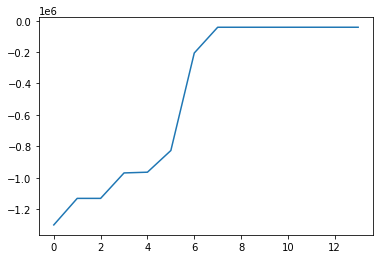

In [33]:
model, map_soln, extras, start, opti_logp = build_model(lc_gp_params=working_params[np.argmax(final_model_logp)])

fig,ax = plt.subplots()
ax.plot(range(len(opti_logp)), opti_logp)

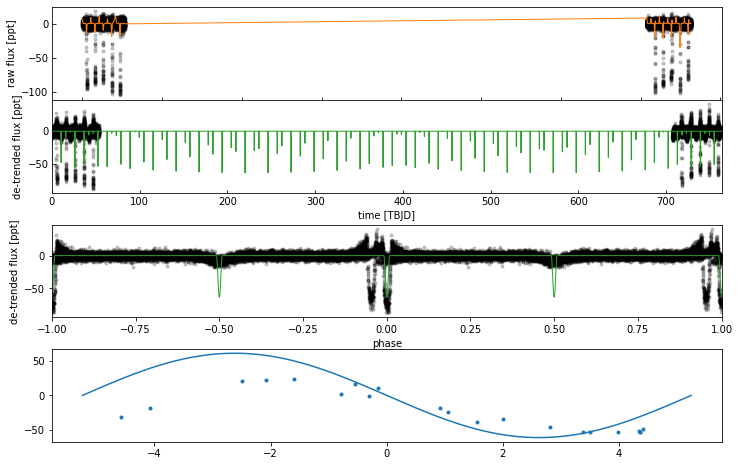

In [34]:
def plot_diagnostic_plots(soln, extras, mask):
    if mask is None:
        mask = np.ones(len(extras['x']), dtype=bool)
    
    if 'period' in soln.keys():
        period = soln['period']
    elif 'log_period' in soln.keys():
        period = np.exp(soln['log_period'])
    else:
        period = np.exp(soln['log_period_interval__'])
        
    x = extras['x'][mask]
    y = extras['y'][mask]
    t_lc_pred = np.linspace(x.min(), x.max(), 3000)
    
    t0 = soln['t0']
    mean = soln['mean_rv']
    x_phase = np.linspace(-0.5*period, 0.5*period, 1000)
    
    x_rv = extras['x_rv']
    y_rv = extras['y_rv']
    
    with model:
        gp_pred = (
            pmx.eval_in_model(extras["gp_lc_pred"], soln) + soln["mean_lc"]
        )
        lc = (
            pmx.eval_in_model(extras["model_lc"](t_lc_pred), soln)
            - soln["mean_lc"]
        )

        y_rv_mod = pmx.eval_in_model(
            extras['model_rv'](x_phase + t0), soln
        )
    
    # fig, axes = plt.subplots(nrows=3)
    gsfig = GridSpec(nrows=140,ncols=100)
    fig = plt.figure(figsize=(12,8), constrained_layout=False)



    ax1 = fig.add_subplot(gsfig[:30,:])
    ax2 = fig.add_subplot(gsfig[30:60,:])
    ax3 = fig.add_subplot(gsfig[70:100,:])
    ax4 = fig.add_subplot(gsfig[110:,:])
    
    ax1.tick_params(labelbottom=False,direction='in')
    ax2.tick_params(bottom=True,direction='in')

    ax1.plot(x, y, "k.", alpha=0.2)
    ax1.plot(x, gp_pred[mask], color="C1", lw=1)
    ax2.set_xlim(x.min(), y.max())

    ax2.plot(x, y - gp_pred, "k.", alpha=0.2)
    ax2.plot(t_lc_pred, lc, color="C2", lw=1)
    ax2.set_xlim(x.min(), x.max())

    ax1.set_ylabel("raw flux [ppt]")
    ax2.set_ylabel("de-trended flux [ppt]")
    ax2.set_xlabel("time [TBJD]")



    x_fold = (
        (extras["x"][mask] - t0) % period / period
    )
    inds = np.argsort(x_fold)

    ax3.plot(x_fold[mask][inds], extras["y"][mask][inds] - gp_pred[mask][inds], "k.", alpha=0.2)
    ax3.plot(x_fold[mask][inds] - 1, extras["y"][mask][inds] - gp_pred[mask][inds], "k.", alpha=0.2)
#     ax2.plot(
#         x_fold[mask][inds],
#         extras["y"][mask][inds] - gp_pred[mask][inds],
#         "k.",
#         alpha=0.2,
#         label="data!",
#     )
#     ax2.plot(x_fold[inds] - 1, extras["y"][inds] - gp_pred, "k.", alpha=0.2)

    yval = extras["y"][inds] - gp_pred
    bins = np.linspace(0, 1, 75)
    num, _ = np.histogram(x_fold[inds], bins, weights=yval)
    denom, _ = np.histogram(x_fold[inds], bins)
#     ax2.plot(0.5 * (bins[:-1] + bins[1:]) - 1, num / denom, ".w")

    args = dict(lw=1)

    x_fold = (t_lc_pred - t0) % period / period
    inds = np.argsort(x_fold)
    ax3.plot(x_fold[inds], lc[inds], "C2", **args)
    ax3.plot(x_fold[inds] - 1, lc[inds], "C2", **args)

    ax3.set_xlim(-1, 1)
    ax3.set_ylabel("de-trended flux [ppt]")
    ax3.set_xlabel("phase")
    
    x_rv_fold = (x_rv - t0 + 0.5*period) % period - 0.5*period
    ax4.plot(x_phase, y_rv_mod - mean, "C0")
    ax4.plot(fold(x_rv,period,t0), y_rv-mean, ".", label='RV obs')
    
plot_diagnostic_plots(start, extras, mask=None)

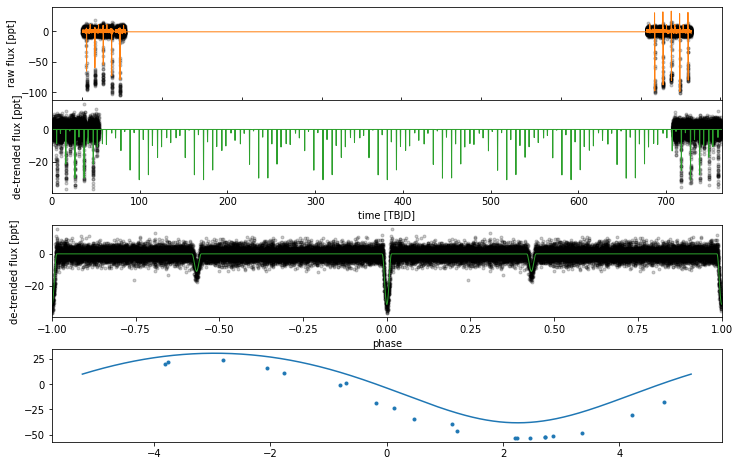

In [35]:
plot_diagnostic_plots(map_soln, extras, mask=None)

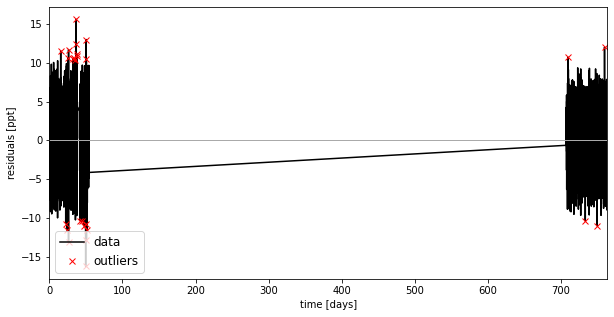

In [36]:
with model:
    mod = pmx.eval_in_model(
        extras['model_lc'](extras['x']) + extras['gp_lc_pred'],
        map_soln,
    )
    
resid = y - mod
rms = np.sqrt(np.median(resid ** 2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
_ = plt.xlim(x.min(), x.max())

optimizing logp for variables: [mean_lc, u2, u1]


message: Optimization terminated successfully.
logp: -41321.10702363196 -> -41321.05255165215
optimizing logp for variables: [t0, log_period]


message: Optimization terminated successfully.
logp: -41321.05255165215 -> -41321.018075028034
optimizing logp for variables: [logK]


message: Optimization terminated successfully.
logp: -41321.018075028034 -> -41321.018075028034
optimizing logp for variables: [log_q]


message: Optimization terminated successfully.
logp: -41321.018075028034 -> -41321.016350565544
optimizing logp for variables: [log_s]


message: Optimization terminated successfully.
logp: -41321.016350565544 -> -41314.885900524234
optimizing logp for variables: [log_k, b, ecs]


message: Optimization terminated successfully.
logp: -41314.885900524234 -> -41310.45739285327
optimizing logp for variables: [sigma_lc, sigma_gp, rho_gp, mean_lc]


message: Optimization terminated successfully.
logp: -41310.45739285327 -> -41310.4117934138
optimizing logp for variables: [log_sigma_rv]


message: Optimization terminated successfully.
logp: -41310.4117934138 -> -41310.41171920246
optimizing logp for variables: [u2, u1, mean_lc]


message: Optimization terminated successfully.
logp: -41310.41171920246 -> -41310.32299551727
optimizing logp for variables: [log_M1]


message: Optimization terminated successfully.
logp: -41310.32299551727 -> -41308.58513298007
optimizing logp for variables: [log_R1]


message: Optimization terminated successfully.
logp: -41308.58513298007 -> -41308.57182464808
optimizing logp for variables: [t0, log_period]


message: Desired error not necessarily achieved due to precision loss.
logp: -41308.57182464808 -> -41308.289242576895
optimizing logp for variables: [log_q]


message: Optimization terminated successfully.
logp: -41308.289242576895 -> -41308.11643459856
optimizing logp for variables: [log_sigma_rv]


message: Optimization terminated successfully.
logp: -41308.11643459856 -> -41308.11366153977


14419 14393


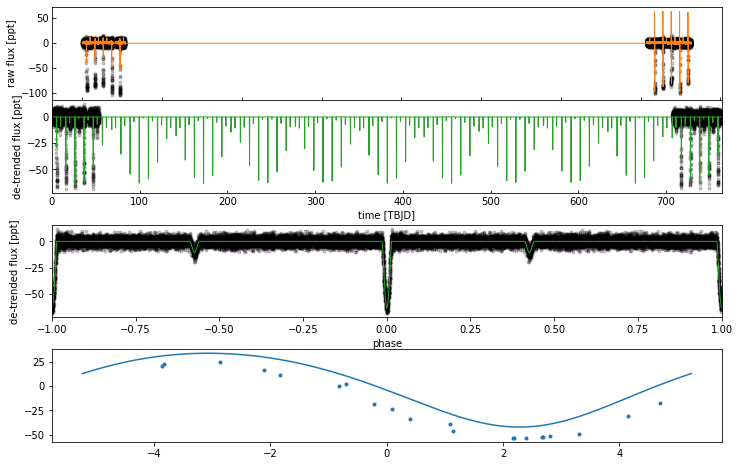

In [38]:
model, map_soln, extras, start, opti_logp = build_model(mask, map_soln, lc_gp_params=working_params[np.argmax(final_model_logp)])
print(len(mask), len(extras['x']))
plot_diagnostic_plots(map_soln, extras, mask=None)
plt.savefig("/Users/kjaehnig/CCA_work/GAT/figs/diagnostic_lightcurves_w_model_after_outlier_removal_w_s1_params.png", dpi=150, bbox_inches='tight')

In [39]:
with model:
    trace = pm.sample(
        tune=100,
        draws=50,
        start=map_soln,
        # Parallel sampling runs poorly or crashes on macos
        cores=4,
        chains=2,
        target_accept=0.95,
        return_inferencedata=True,
        random_seed=[261136681, 261136682],#,261136683,261136684],
        init='adapt_full'
    )

Only 50 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [log_sigma_rv, rho_gp, sigma_gp, sigma_lc, ecs, t0, log_period, b, log_s, log_q, logK, log_k, log_R1, log_M1, u2, u1, mean_rv, mean_lc]


Sampling 2 chains for 100 tune and 50 draw iterations (200 + 100 draws total) took 449 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


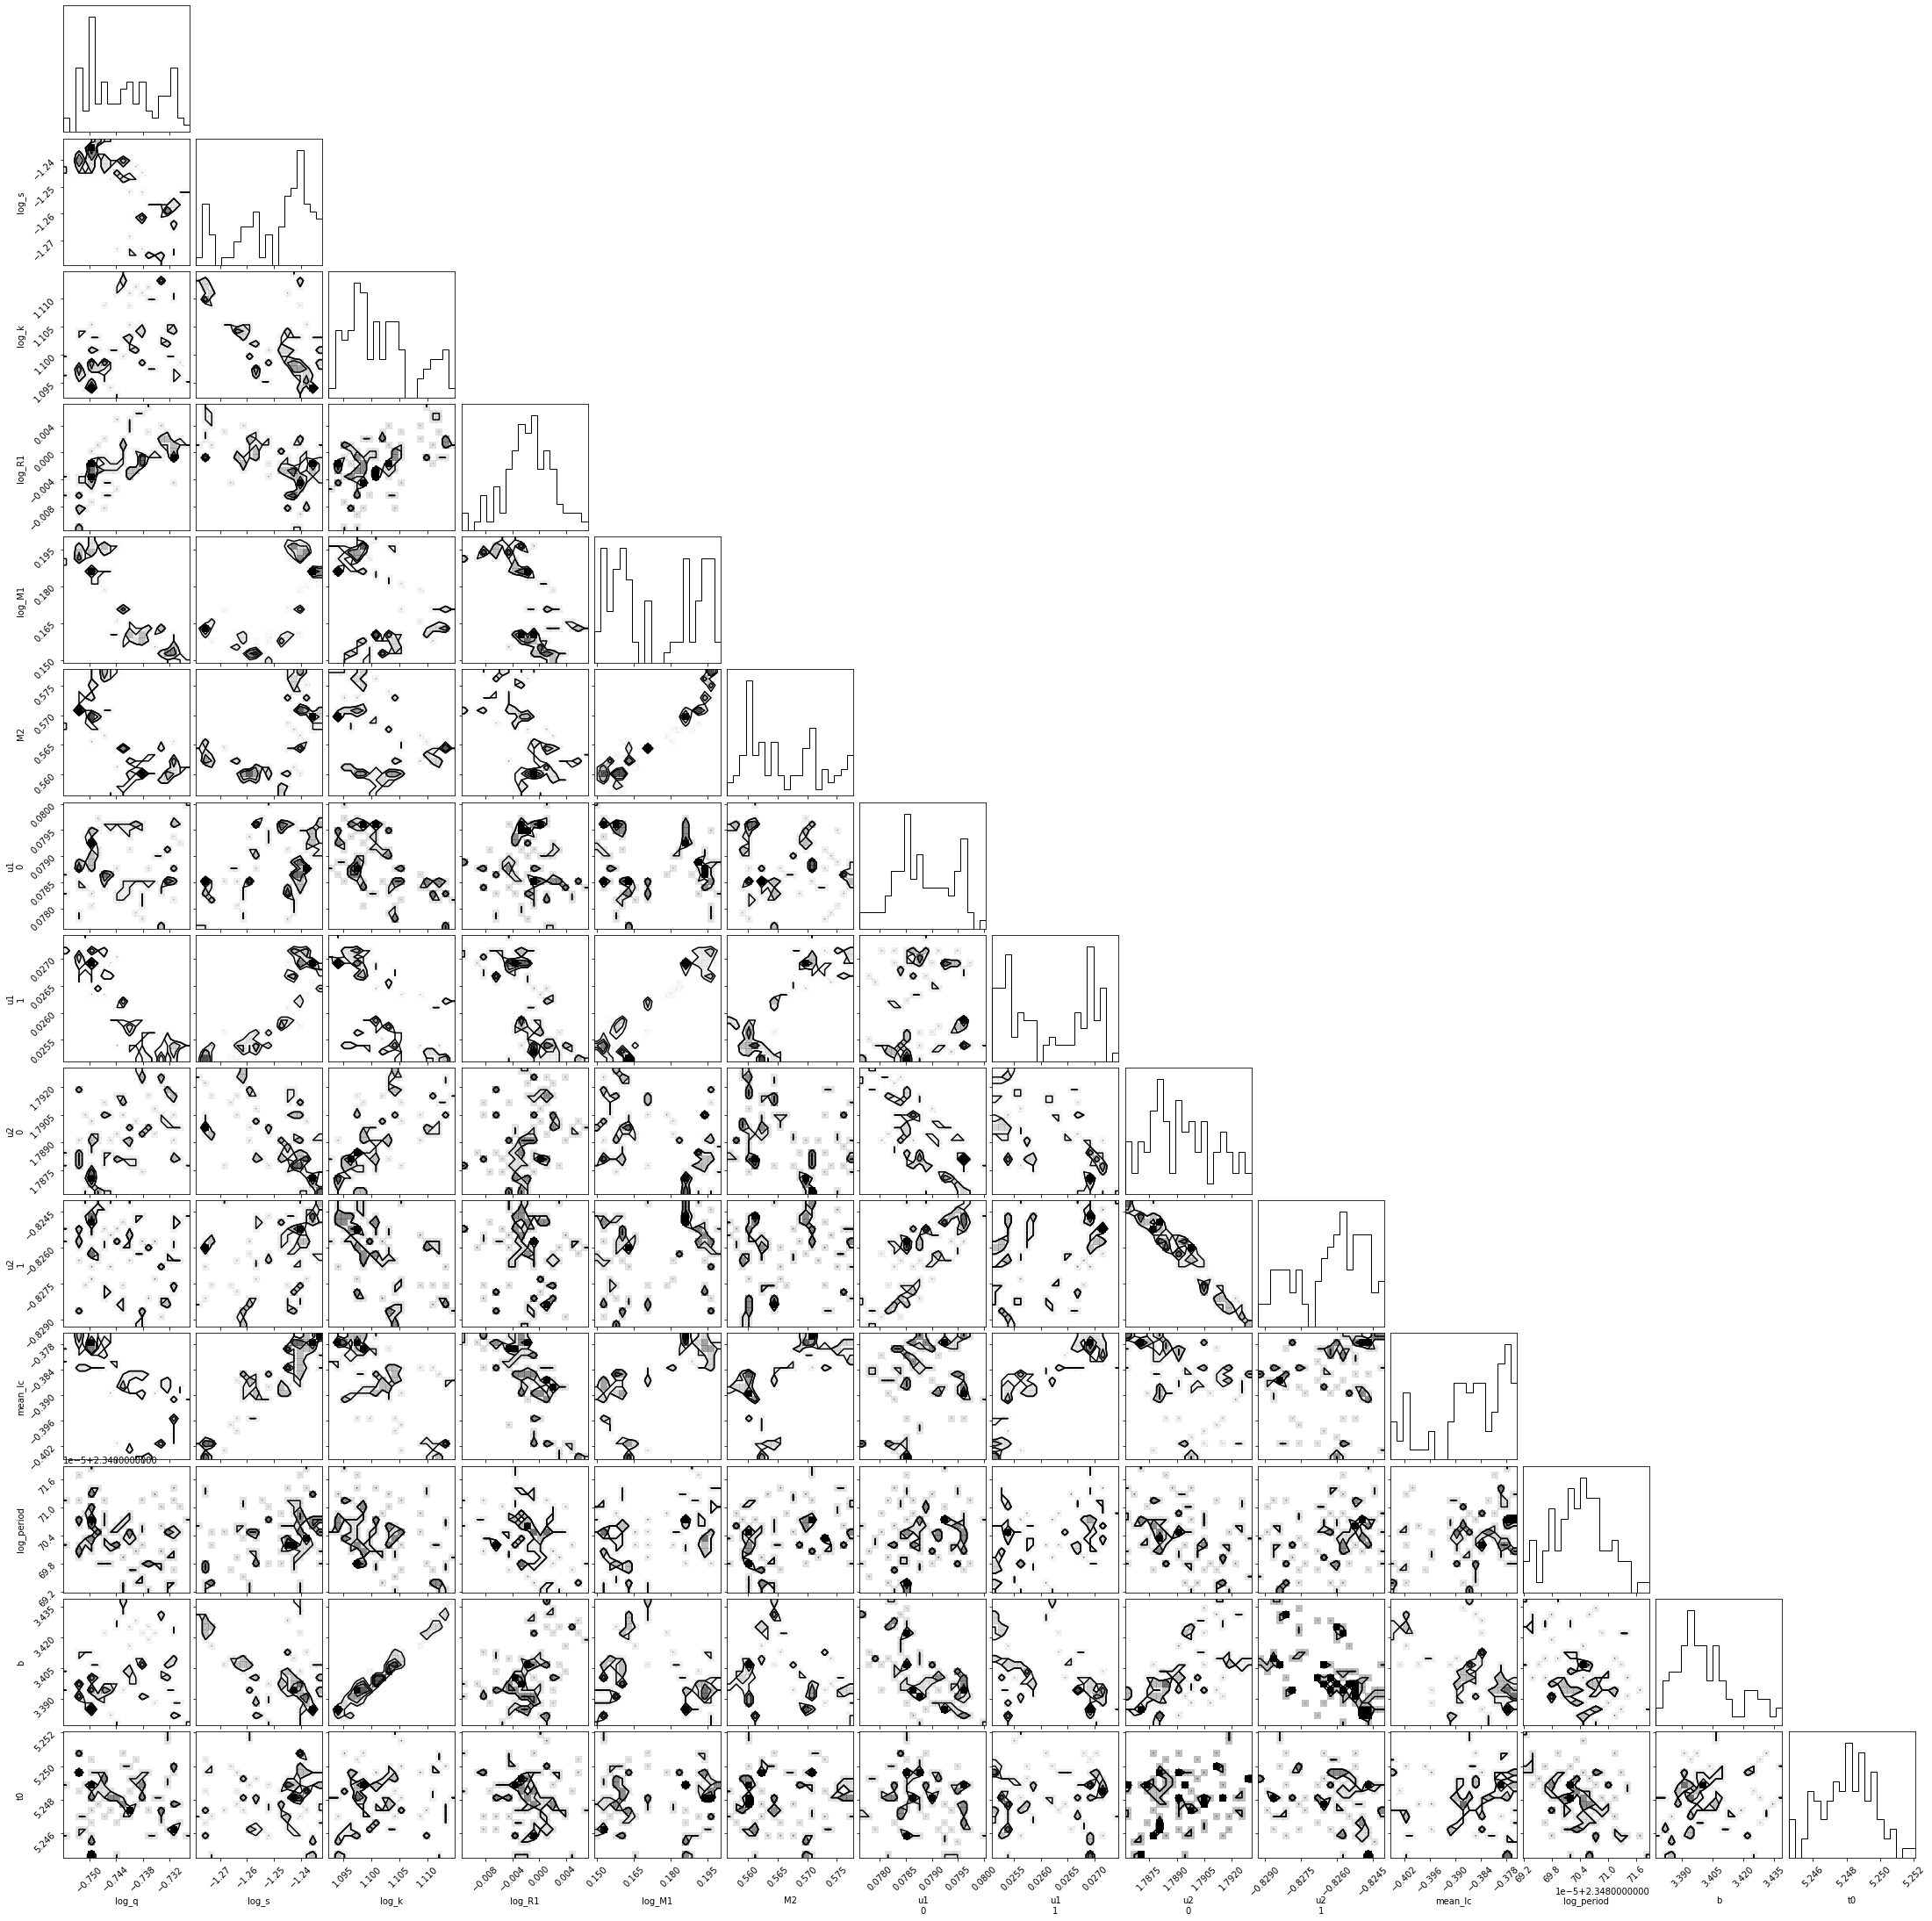

In [40]:
_ = corner(trace, var_names=['log_q','log_s','log_k','log_R1','log_M1','M2','u1','u2','mean_lc','log_period','b','t0'])

In [41]:
az.summary(trace, var_names=['log_q','log_s','log_k','log_R1','log_M1','u1','u2','mean_lc','log_period','b','t0'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_q,-0.742,0.007,-0.753,-0.730,0.004,0.004,3.0,31.0,1.94
log_s,-1.250,0.013,-1.276,-1.234,0.008,0.006,3.0,23.0,2.23
log_k,1.102,0.006,1.094,1.113,0.002,0.001,10.0,45.0,1.20
log_R1,-0.002,0.004,-0.009,0.005,0.002,0.001,4.0,14.0,1.61
log_M1,0.173,0.017,0.152,0.197,0.011,0.009,3.0,27.0,2.01
u1[0],0.079,0.001,0.078,0.080,0.000,0.000,18.0,58.0,1.11
u1[1],0.026,0.001,0.025,0.027,0.000,0.000,3.0,19.0,2.19
u2[0],1.789,0.002,1.786,1.792,0.000,0.000,13.0,17.0,1.12
u2[1],-0.826,0.001,-0.829,-0.824,0.000,0.000,16.0,39.0,1.06
mean_lc,-0.386,0.008,-0.404,-0.376,0.005,0.004,3.0,16.0,2.08


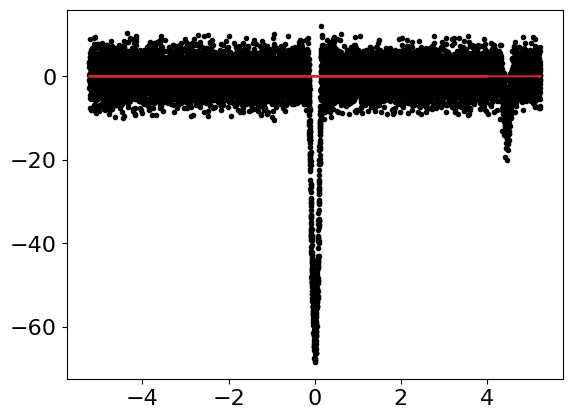

In [42]:
xo.utils.docs_setup()
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

# Compute the GP prediction
with model:
    gp_pred = (
        pmx.eval_in_model(extras["gp_lc_pred"], map_soln) + map_soln["mean_lc"]
    )

# Get the posterior median orbital parameters
p = np.median(flat_samps["period"])
t0 = np.median(flat_samps["t0"])
ecc = np.median(flat_samps['ecc'])
omega = np.median(flat_samps['omega'])
b = np.median(flat_samps['b'])
R1 = np.median(flat_samps['R1'])
R2 = np.median(flat_samps['R2'])
M1 = np.median(flat_samps['M1'])
M2 = np.median(flat_samps['M2'])
u1 = np.median(flat_samps['u1'],axis=-1)
u2 = np.median(flat_samps['u2'],axis=-1)
s = np.median(flat_samps['s'])
mean_lc = np.median(flat_samps['mean_lc'])

vars_of_interest = ["period", "t0",
                    "ecc", "omega","b",
                    "R1","M1","R2","M2",
                    "u1","u2",'s']

orbit = xo.orbits.KeplerianOrbit(
    period=p,
    t0=t0,
    ecc=ecc,
    omega=omega,
    b=b,
    r_star=R2,
    m_star=M2,
    m_planet=M1,
)


light_curve = (
    xo.SecondaryEclipseLightCurve(u1, u2, s)
    .get_light_curve(orbit=orbit, r=R1, t=x[mask], texp=texp)
).eval()

# Plot the folded data
x_fold = (x[mask] - t0 + 0.5 * p) % p - 0.5 * p
plt.plot(x_fold, y[mask] - gp_pred, ".k", label="data", zorder=-1000)
plt.plot(x_fold, light_curve, c='C3')

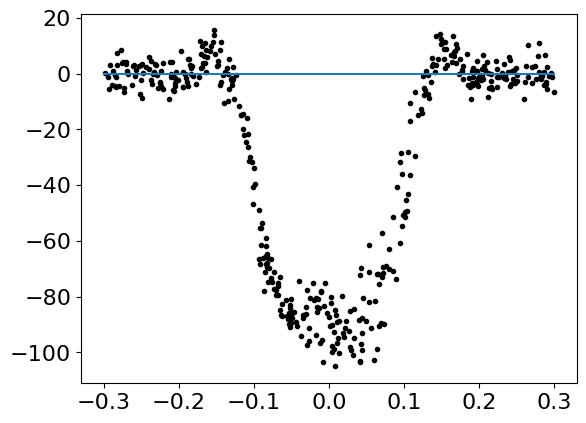

In [303]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))
# for data_var in flat_samps.data_vars.keys():
#     print(data_var)
plt.figure()



# Get the posterior median orbital parameters
p = np.median(flat_samps["period"])
t0 = np.median(flat_samps["t0"])

# Plot the folded data
x_fold = (x[mask] - t0 + 0.5 * p) % p - 0.5 * p
m = np.abs(x_fold) < 0.3
plt.plot(
    x_fold[m], y[mask][m], ".k", label="data", zorder=-1000
)


lcpred = np.percentile(flat_samps['lc_pred'], 50,axis=0)
mod_phase = np.linspace(-.3, 0.3, len(lcpred))
plt.plot(mod_phase, lcpred)